In [1]:
#引入spark
import findspark
findspark.init()
import pyspark

#sparkSQL
from pyspark.sql import SQLContext
from pyspark.sql.types import *

#结巴分词
import jieba
import jieba.analyse
jieba.enable_parallel(4)
jieba.load_userdict('/notebooks/ciku/words-360w.res.txt')
jieba.analyse.set_stop_words('/notebooks/ciku/chinese_stopword.txt')

#BeautifulSoup,剔除HTML标签
from BeautifulSoup import BeautifulSoup

#图表生成
import matplotlib.pyplot as plt
%matplotlib inline
#词云
from wordcloud import WordCloud

#清洗规则
import re 
facePatt = re.compile(r'\[.*?\]') 
namePatt = re.compile(r'^@.*') 
punct = set(u'''|▲/#:!),.:;?]}¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒
﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠
々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻
︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
# 对str/unicode
filterpunt = lambda s: ''.join(filter(lambda x: x not in punct, s))
#分词，清洗
def sp(row):
    soup = BeautifulSoup(row.weibo_content).findAll(text=True)
    res = list()
    for ct in soup:
        ct = namePatt.sub('',facePatt.sub('', filterpunt(ct)))
        if ct is not None and ct != '':
            res += jieba.cut(ct)
    return res


#初始化sparkContext
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

#生成停止词RDD
stopWordRDD = sc.textFile("file:///notebooks/ciku/chinese_stopword.txt")
stopWordRDD = sc.parallelize([(word,1) for word in stopWordRDD.collect()])

#生成词典RDD
dictSchema = StructType([ \
    StructField("word",StringType(),True), \
    StructField("freq",StringType(),True), \
    StructField("prop",StringType(),True)
])
dictDF = sqlContext.load(source="com.databricks.spark.csv", path = "/notebooks/ciku/words-360w.res.txt",schema = dictSchema,delimiter=" ")
dictRDD = dictDF.select('word','prop').rdd.map(tuple)

if sqlContext:
    print "Spark 初始化完成"

    
from graphframes import GraphFrame


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.372 seconds.
Prefix dict has been built succesfully.
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/spark/python/pyspark/sql/context.py:535: UserWarning: load is deprecated. Use read.load() instead.
  warnings.warn("load is deprecated. Use read.load() instead.")


Spark 初始化完成


In [2]:
#定义数据结构
customSchema = StructType([ \
    StructField("Id",LongType(),True), \
    StructField("crawler_time",TimestampType(),True), \
    StructField("crawler_time_stamp",LongType(),True), \
    StructField("is_retweet",ByteType(),True), \
    StructField("user_id",LongType(),True), \
    StructField("nick_name",StringType(),True), \
    StructField("tou_xiang",StringType(),True), \
    StructField("user_type",StringType(),True), \
    StructField("weibo_id",LongType(),True), \
    StructField("weibo_content",StringType(),True), \
    StructField("zhuan",IntegerType(),True), \
    StructField("ping",IntegerType(),True), \
    StructField("zhan",IntegerType(),True), \
    StructField("url",StringType(),True), \
    StructField("device",StringType(),True), \
    StructField("locate",StringType(),True), \
    StructField("time",TimestampType(),True), \
    StructField("time_stamp",LongType(),True), \
    StructField("r_user_id",LongType(),True), \
    StructField("r_nick_name",StringType(),True), \
    StructField("r_user_type",StringType(),True), \
    StructField("r_weibo_id",LongType(),True), \
    StructField("r_weibo_content",StringType(),True), \
    StructField("r_zhuan",IntegerType(),True), \
    StructField("r_ping",IntegerType(),True), \
    StructField("r_zhan",IntegerType(),True), \
    StructField("r_url",StringType(),True), \
    StructField("r_device",StringType(),True), \
    StructField("r_location",StringType(),True), \
    StructField("r_time",TimestampType(),True), \
    StructField("r_time_stamp",LongType(),True), \
    StructField("pic_content",StringType(),True)
])

#读入微博数据
df = sqlContext.load(source="com.databricks.spark.csv", path = "/notebooks/weibo/weibo_freshdata.2016-05-01",schema = customSchema,delimiter="\t")

if df:
    print "df 创建成功"
#df.select("year", "model").save("newcars.csv", "com.databricks.spark.csv")


df 创建成功


In [3]:
#选择数据
user = df[(df.time >= '2016-05-01 00:00:00') & (df.time <= '2016-05-01 03:00:00')]
print '已选择 %s 条数据...'%(user.count())
#分词
test = user.select('weibo_content').map(sp).collect()
#数词
rdd = sc.parallelize([(word,1) for line in test for word in line])


已选择 269094 条数据...


TypeError: object of type 'int' has no len()

In [4]:
print '分成 %s 个词条...'%(rdd.count())

wcount = sc.parallelize(rdd.filter(lambda x: len(x[0]) >1).countByKey().items())
#排除停止词
wcount = wcount.subtractByKey(stopWordRDD)#.collect()

#排序
top100RDD = wcount.sortBy(lambda x: x[1],ascending=False)
top100 = top100RDD.collect()[:100]
#top100[:10]

#?????????

#关联词性
joinedRDD = top100RDD.leftOuterJoin(dictRDD)
joinedRDD.count()

分成 11936494 个词条...


155498

In [5]:
top100RDD2 = joinedRDD.sortBy(lambda x: x[1][0],ascending=False)
top1002 = top100RDD2.collect()[:100]
#for word,(count,prop) in top1002:
#    print word,count,prop
#for word,(count,_) in top100N:
#    print word,count 
top1002[:1]

[(u'\u559c\u6b22', (20211, u'v'))]

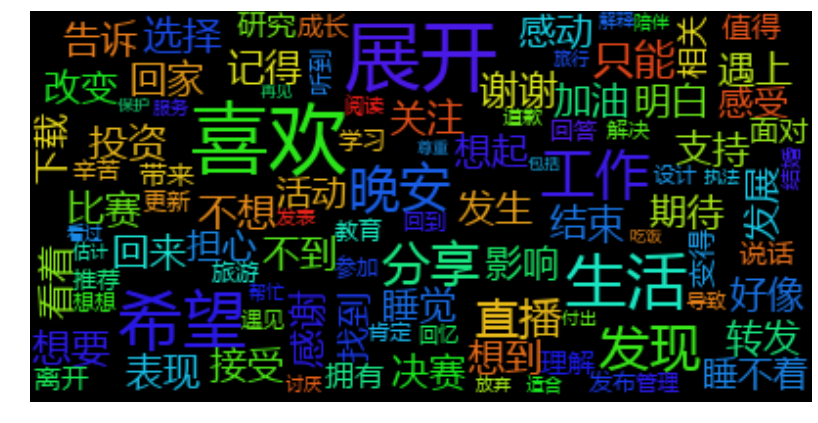

In [11]:
#top100N = top100RDD2.filter(lambda x : x[1][1] is not None and x[1][1].startswith('nr')).collect()[:100]
top100N = top100RDD2.filter(lambda x : x[1][1] is not None and x[1][1].startswith('v')).collect()[:100]
#top100N = top100RDD2.filter(lambda x : x[1][1] is not None and x[1][1].startswith('b')).collect()[:100]
#top100N = top100RDD2.filter(lambda x : x[1][1] is not None and x[1][1].startswith('n')).collect()[:100]
#top100N = top100RDD2.filter(lambda x : x[1][1] is not None and x[1][1].startswith('v')).collect()[:100]
#top100N = top100RDD2.filter(lambda x : x[1][1] is not None and x[1][1] == 't').collect()[:100]

plt.figure(figsize=(14,10))  

#wordcloud = WordCloud(font_path="/usr/local/lib/python2.7/dist-packages/wordcloud/yahei.ttf").fit_words([(word,freq) for word,(freq,_) in top100N])
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).fit_words([(word,freq) for word,(freq,_) in top100N])
plt.imshow(wordcloud)
plt.axis("off")

plt.show()


In [ ]:
#user.select('user_id').collect()[:10]
user.cache()

In [ ]:
#df.select('r_weibo_id').collect()
forward = df.filter(df['r_weibo_id'] != 0)


In [50]:
locate = df.filter(df['locate'] != '')
locate.count()

324883

In [51]:
locate.select('locate').show()

+----------+
|    locate|
+----------+
|  亳州·庄周...|
|  拉萨·柳梧...|
|    禹城·张庄镇|
|  西安·中建...|
|        晋城|
|南京·UME国...|
|  广州·一记...|
|  武汉·狮子...|
|  黄石·湖北...|
|  拉萨·柳梧...|
|  宁波·五乡...|
|        昆明|
|  北京·工体...|
|     武汉·二七|
|  北京·泉河...|
|        湘潭|
|  长沙·洪山...|
|  九江·名湖...|
|  南宁·西乡...|
|  平顶山·焦...|
+----------+
only showing top 20 rows



In [48]:
forward.select('Id','r_weibo_id','user_id','r_user_id').show()

+---------+----------------+----------+----------+
|       Id|      r_weibo_id|   user_id| r_user_id|
+---------+----------------+----------+----------+
|868216818|3969893399221390|2911023347|2083131963|
|868216819|3970048903357044|2911023347|2858947502|
|868216820|3970054511419391|2911023347|5044759487|
|868216822|3970047850461274|2911023347|5286042366|
|868216823|3969729980561917|2911023347|2402670021|
|868216824|3969897212243186|2911023347|3783827585|
|868216825|3969708439064412|2911023347|5048304882|
|868217067|3969875854255553|3509220864|2182537064|
|868217068|3970052912669743|3509220864|1792890952|
|868217069|3970008192973263|3509220864|3603312092|
|868217070|3969916036638290|3509220864|5598278574|
|868217071|3964570815047497|3509220864|2721695512|
|868217072|3969777640708883|3509220864|2543638965|
|868217073|3969777640708883|3509220864|2543638965|
|868217074|3969688922990066|3509220864|2173825475|
|868219605|3969947703677821|1901872085|1863089382|
|868219606|3969901448875035|190

In [45]:
fwdf = forward.select(forward['Id'],forward['r_weibo_id'])
df.registerTempTable("weibo")
forward.registerTempTable("forward")
joinedTB = sqlContext.sql("SELECT * FROM weibo w inner join forward f on w.Id=f.r_weibo_id")
joinedTB.count()
#fwdf.show()

0

In [17]:
v = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
# Create an Edge DataFrame with "src" and "dst" columns
e = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
# Create a GraphFrame
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, numIter=20)
results.vertices.select("id", "pagerank").show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       1|
+---+--------+



TypeError: pageRank() got an unexpected keyword argument 'numIter'

In [51]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vectors
#导入数据
data = [(Vectors.dense([0.0, 0.0]),), (Vectors.dense([1.0, 1.0]),),(Vectors.dense([9.0, 8.0]),), (Vectors.dense([8.0, 9.0]),)]
